# Assignment 7 Solutions: Predictive Modeling of Housing Prices in Philadelphia

**NOTE: THIS ASSIGNMENT IS REQUIRED**.

**Due date: Wednesday, 12/7 by the end of the day**

The notebook should be submitted to your own private repository on GitHub, which can be created using the following link:

https://classroom.github.com/a/1chu7Fxgm

## Part 1: Proposal for the final project

Submit a short (1/2 to 1 page) proposal that outlines and describe your plan for the final project. The proposal should discuss the following aspects of the project:

- the data set(s) you wish to use in the project,
- the questions that you want to explore
- the analysis methods and techniques that you will use 
- how the above items satisfy the requirements outlined in the [final project description](https://github.com/MUSA-550-Fall-2021/final-project)

The description of the final project can be found [here](https://github.com/MUSA-550-Fall-2021/final-project).

**Note:** if you are struggling to come up with ideas for datasets, analyses, etc, please reach out and we can discuss potential project ideas.


#### Deliverable

Upload a word document, PDF, etc to the assignment's GitHub repository with your proposal.

#### Note
For the moment, do not worry too much about how the visualizations/interactive maps will be hosted on the web. We will cover several methods for embedding your visualizations on the web in the coming weeks. These methods fall generally into three categories:

- embedding interactive altair/holoviews plots produced in Python
- creating an interactive dashboard of plots using a free-tier server to host your code

Much more on these methods in the coming weeks!


## Part 2: Modeling Philadelphia's Housing Prices

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
import numpy as np
import pandas as pd
import geopandas as gpd

In [30]:
np.random.seed(42)

In [31]:
from matplotlib import pyplot as plt

### 2.1 Load data from the Office of Property Assessment

Use `carto2gpd` to load data for **single-family** properties in Philadelphia that had their **last sale during 2021**.

Sources: 
- [OpenDataPhilly](https://www.opendataphilly.org/dataset/opa-property-assessments)
- [Metadata](http://metadata.phila.gov/#home/datasetdetails/5543865f20583086178c4ee5/representationdetails/55d624fdad35c7e854cb21a4/)

In [32]:
import carto2gpd

In [33]:
# the CARTO API url
carto_url = "https://phl.carto.com/api/v2/sql"

# The table name
table_name = "opa_properties_public"

# Only pull 2021 sales for single family residential properties
where = "sale_date >= '2021-01-01' and sale_date <= '2021-12-31'"
where = where + " and category_code_description IN ('SINGLE FAMILY', 'Single Family')"

# Run the query
salesRaw = carto2gpd.get(carto_url, table_name, where=where)

In [34]:
salesRaw.head()

,geometry,cartodb_id,assessment_date,basements,beginning_point,book_and_page,building_code,building_code_description,category_code,category_code_description,...,unfinished,unit,utility,view_type,year_built,year_built_estimate,zip_code,zoning,pin,objectid
0,POINT (-75.19667 39.93733),968,2021-07-16T00:00:00Z,None,164' S WHARTON ST,54096200,O30,ROW 2 STY MASONRY,1,SINGLE FAMILY,...,None,None,None,I,1925,Y,19146,RSA5,1001649631,233905989
1,POINT (-75.16623 39.94166),983,2022-03-09T00:00:00Z,A,SWC BROAD & FITZWATER STS,53950012,SC,VACANT LAND COMMER < ACRE,1,SINGLE FAMILY,...,None,None,None,I,2021,None,19146,CMX3,1001681202,233905945
2,POINT (-75.02846 40.11039),1074,2021-07-16T00:00:00Z,F,"89'11 1/2"" NE SEL459",54095903,K30,S/D W/B GAR 2 STY MASONRY,1,SINGLE FAMILY,...,None,None,None,I,1968,Y,19116,RSA3,1001476645,233906090
3,POINT (-75.14689 40.05641),1194,2021-07-16T00:00:00Z,H,"152'6"" N 67TH AVE",54095296,R30,ROW B/GAR 2 STY MASONRY,1,SINGLE FAMILY,...,None,None,None,I,1925,Y,19126,RSA5,1001097499,233906209
4,POINT (-75.12769 39.99808),1292,2021-07-16T00:00:00Z,D,"429'4"" E FRONT ST",54094828,O30,ROW 2 STY MASONRY,1,SINGLE FAMILY,...,None,None,None,I,1920,Y,19134,RM1,1001058475,233906306


In [35]:
len(salesRaw)

25747

### 2.2 Load data for census tracts and neighborhoods

Load various Philadelphia-based regions we will use in our analysis.

- Census tracts can be downloaded from: http://data.phl.opendata.arcgis.com/datasets/8bc0786524a4486bb3cf0f9862ad0fbf_0.geojson
- Neighborhoods can be downloaded from:
https://raw.githubusercontent.com/azavea/geo-data/master/Neighborhoods_Philadelphia/Neighborhoods_Philadelphia.geojson


In [36]:
import esri2gpd

In [37]:
# Neighborhoods
url = "https://raw.githubusercontent.com/azavea/geo-data/master/Neighborhoods_Philadelphia/Neighborhoods_Philadelphia.geojson"
hoods = (
    gpd.read_file(url)
    .to_crs(epsg=4326)
    .rename(columns={"mapname": "neighborhood"})
)

In [38]:
# Census tracts
url = "http://data.phl.opendata.arcgis.com/datasets/8bc0786524a4486bb3cf0f9862ad0fbf_0.geojson"
tracts = gpd.read_file(url)

### 2.3 Spatially join the sales data and neighborhoods/census tracts.

Perform a spatial join, such that each sale has an associated neighborhood and census tract.

**Note:** after performing the first spatial join, you will need to use the `drop()` function to remove the `index_right` column; otherwise an error will be raised on the second spatial join about duplicate columns.

In [39]:
# Join sales with hoods
salesRaw = gpd.sjoin(salesRaw, hoods, predicate='within')

In [40]:
# Remove index_right
salesRaw = salesRaw.drop(labels=['index_right'], axis=1)

In [41]:
# Join sales with tracts
salesRaw = gpd.sjoin(salesRaw, tracts, predicate='within')

### 2.4 Train a Random Forest on the sales data

You should follow the steps outlined in lecture to preprocess and train your model. 

**Extra credit: the students with the top 3 scores on the test set will receive extra credit (first place +3, second place +2, third place +1)**

**Requirements**
- Trim the sales data to those sales with prices between \\$3,000 and \\$1 million
- Set up a pipeline that includes both numerical columns and categorical columns
- Include one-hot encoded variables for the neighborhood of the sale
- Use a 70/30% training/test split
- Use GridSearchCV to perform a $k$-fold cross validation that optimize *at least 2* hyperparameters of the RandomForestRegressor
- After fitting your model and finding the optimal hyperparameters, you should evaluate the score ($R^2$) on the test set (the original 30% sample withheld)

**Notes**

- You are welcome to include additional features or perform any feature engineering that you want to try to improve the test accuracy
- You can also experiment with the prediction variable, e.g., try predicting sale price per sq ft. (or its log)

In [42]:
# The feature columns we want to use
cols = [
    "sale_price",
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
    "exterior_condition",
    "neighborhood",
]

# Trim to these columns and remove NaNs
sales = salesRaw[cols].dropna()

In [43]:
# Trim very low and very high sales
valid = (sales['sale_price'] > 3000) & (sales['sale_price'] < 1e6)
sales = sales.loc[valid]

In [44]:
len(sales)

19286

Do the test/tran split:

In [45]:
# I'll use a 70/30% split
train_set, test_set = train_test_split(sales, test_size=0.3, random_state=42)

# the target labels
y_train = np.log(train_set["sale_price"])
y_test = np.log(test_set["sale_price"])

Setup the preprocessor that will scale and one-hot encode the sales data:

In [46]:
# Numerical columns
num_cols = [
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
]

# Categorical columns
cat_cols = ["exterior_condition", "neighborhood"]

In [47]:
# Set up the column transformer with two transformers
# Scale the numerical columns and one-hot 
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

Set up our pipeline:

In [48]:
# Initialize the pipeline
pipe = make_pipeline(
    preprocessor, RandomForestRegressor(random_state=42)
)

Set up the grid search to optimize two hyperparameters:


In [49]:
# Make the grid of parameters to search
# NOTE: you must prepend the name of the pipeline step
model_name = "randomforestregressor"
param_grid = {
    f"{model_name}__n_estimators": [5, 20, 30, 50, 100],
    f"{model_name}__max_depth": [2, 13, 21, 33, 51, 77],
}

param_grid

{'randomforestregressor__n_estimators': [5, 20, 30, 50, 100],
 'randomforestregressor__max_depth': [2, 13, 21, 33, 51, 77]}

In [50]:
# Create the grid and use 3-fold CV
grid = GridSearchCV(pipe, param_grid, verbose=5, cv=3)

# Run the search
grid.fit(train_set, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 1/3] END randomforestregressor__max_depth=2, randomforestregressor__n_estimators=5;, score=0.217 total time=   0.0s
[CV 2/3] END randomforestregressor__max_depth=2, randomforestregressor__n_estimators=5;, score=0.237 total time=   0.0s
[CV 3/3] END randomforestregressor__max_depth=2, randomforestregressor__n_estimators=5;, score=0.227 total time=   0.0s
[CV 1/3] END randomforestregressor__max_depth=2, randomforestregressor__n_estimators=20;, score=0.234 total time=   0.1s
[CV 2/3] END randomforestregressor__max_depth=2, randomforestregressor__n_estimators=20;, score=0.252 total time=   0.1s
[CV 3/3] END randomforestregressor__max_depth=2, randomforestregressor__n_estimators=20;, score=0.233 total time=   0.1s
[CV 1/3] END randomforestregressor__max_depth=2, randomforestregressor__n_estimators=30;, score=0.234 total time=   0.1s
[CV 2/3] END randomforestregressor__max_depth=2, randomforestregressor__n_estimators=30;, score

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['total_livable_area',
                                                                          'total_area',
                                                                          'garage_spaces',
                                                                          'fireplaces',
                                                                          'number_of_bathrooms',
                                                                          'number_of_bedrooms',
                                                                          'number_stories']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['exterior_condition',
                                                                          'neighborhood'])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'randomforestregressor__max_depth': [2, 13, 21, 33, 51,
                                                              77],
                         'randomforestregressor__n_estimators': [5, 20, 30, 50,
                                                                 100]},
             verbose=5)

In [51]:
# The best estimator
best_estimator = grid.best_estimator_

In [52]:
# The best hyper parameters
grid.best_params_

{'randomforestregressor__max_depth': 51,
 'randomforestregressor__n_estimators': 100}

In [53]:
# Get the R2 on the test set!
best_estimator.score(test_set, y_test)

0.6202875734828799

### 2.5 Calculate the percent error of your model predictions for each sale in the test set

Fit your best model and use it to make predictions on the test set.

**Note:** this should be the percent error in terms of **sale price** or **sale price per sq ft**. You'll need to convert if you predicted the log!

In [54]:
# Make the predictions
predictions = best_estimator.predict(test_set)

# Percent error
# NOTE: we convert from log(sale_price) to sale_price using exp()
errors = (np.exp(predictions) - np.exp(y_test)) / np.exp(y_test) * 100

In [55]:
errors.head()

7189    -13.078482
6403    -50.907698
15927     4.768090
12928   -24.153486
4483     20.492304
Name: sale_price, dtype: float64

### 2.6 Make a data frame with percent errors and census tract info for each sale in the test set

Create a data frame that has the property geometries, census tract data, and percent errors for all of the sales in the test set.

**Notes**

- When using the "train_test_split()" function, the index of the test data frame includes the labels from the original sales data frame
- You can use this index to slice out the test data from the original sales data frame, which should include the census tract info and geometries
- Add a new column to this data frame holding the percent error data



In [57]:
# Extract out the test set data from the original data set
salesTest = salesRaw.loc[test_set.index]

# Add the percent error column
salesTest['percent_error'] =  errors

salesTest.head()

,geometry,cartodb_id_left,assessment_date,basements,beginning_point,book_and_page,building_code,building_code_description,category_code,category_code_description,...,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,LOGRECNO,percent_error
7189,POINT (-75.25485 39.98034),27424,2021-07-16T00:00:00Z,F,113' W OF 66TH ST,53929536,R31,ROW B/GAR 2 STY MAS+OTHER,1,SINGLE FAMILY,...,375,Census Tract 375,G5020,S,1032702,1496,+39.9840699,-075.2551922,10692,-13.078482
6403,POINT (-75.20957 39.95087),26487,2022-04-27T00:00:00Z,D,174' S PINE ST,53946890,O30,ROW 2 STY MASONRY,1,SINGLE FAMILY,...,87.01,Census Tract 87.01,G5020,S,259523,0,+39.9535656,-075.2104988,10421,-50.907698
15927,POINT (-75.16149 39.91909),38018,2022-04-27T00:00:00Z,J,102. S RITNER,53867702,O30,ROW 2 STY MASONRY,1,SINGLE FAMILY,...,41.02,Census Tract 41.02,G5020,S,391854,0,+39.9179425,-075.1600629,10386,4.768090
12928,POINT (-75.23101 39.93057),34348,2021-07-16T00:00:00Z,C,"610'6"" W 60TH ST",53886185,O30,ROW 2 STY MASONRY,1,SINGLE FAMILY,...,66,Census Tract 66,G5020,S,651244,0,+39.9293155,-075.2298425,10399,-24.153486
4483,POINT (-75.22177 39.94926),24168,2021-07-16T00:00:00Z,A,164' W 49 ST,53958724,O50,ROW 3 STY MASONRY,1,SINGLE FAMILY,...,79,Census Tract 79,G5020,S,377950,0,+39.9504630,-075.2182570,10410,20.492304


### 2.7 Plot a map of the median percent error by census tract 

- You'll want to group your data frame of test sales by the `GEOID10` column and take the median of you percent error column
- Merge the census tract geometries back in and use geopandas to plot.

In [58]:
median_errors = tracts.merge(
    salesTest.groupby("GEOID10")["percent_error"].median().reset_index(), on="GEOID10"
)

In [59]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

/var/folders/49/ntrr94q12xd4rq8hqdnx96gm0000gn/T/ipykernel_50391/3658048289.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_yticklabels([f"{x:.0f}%" for x in cax.get_yticks()]);


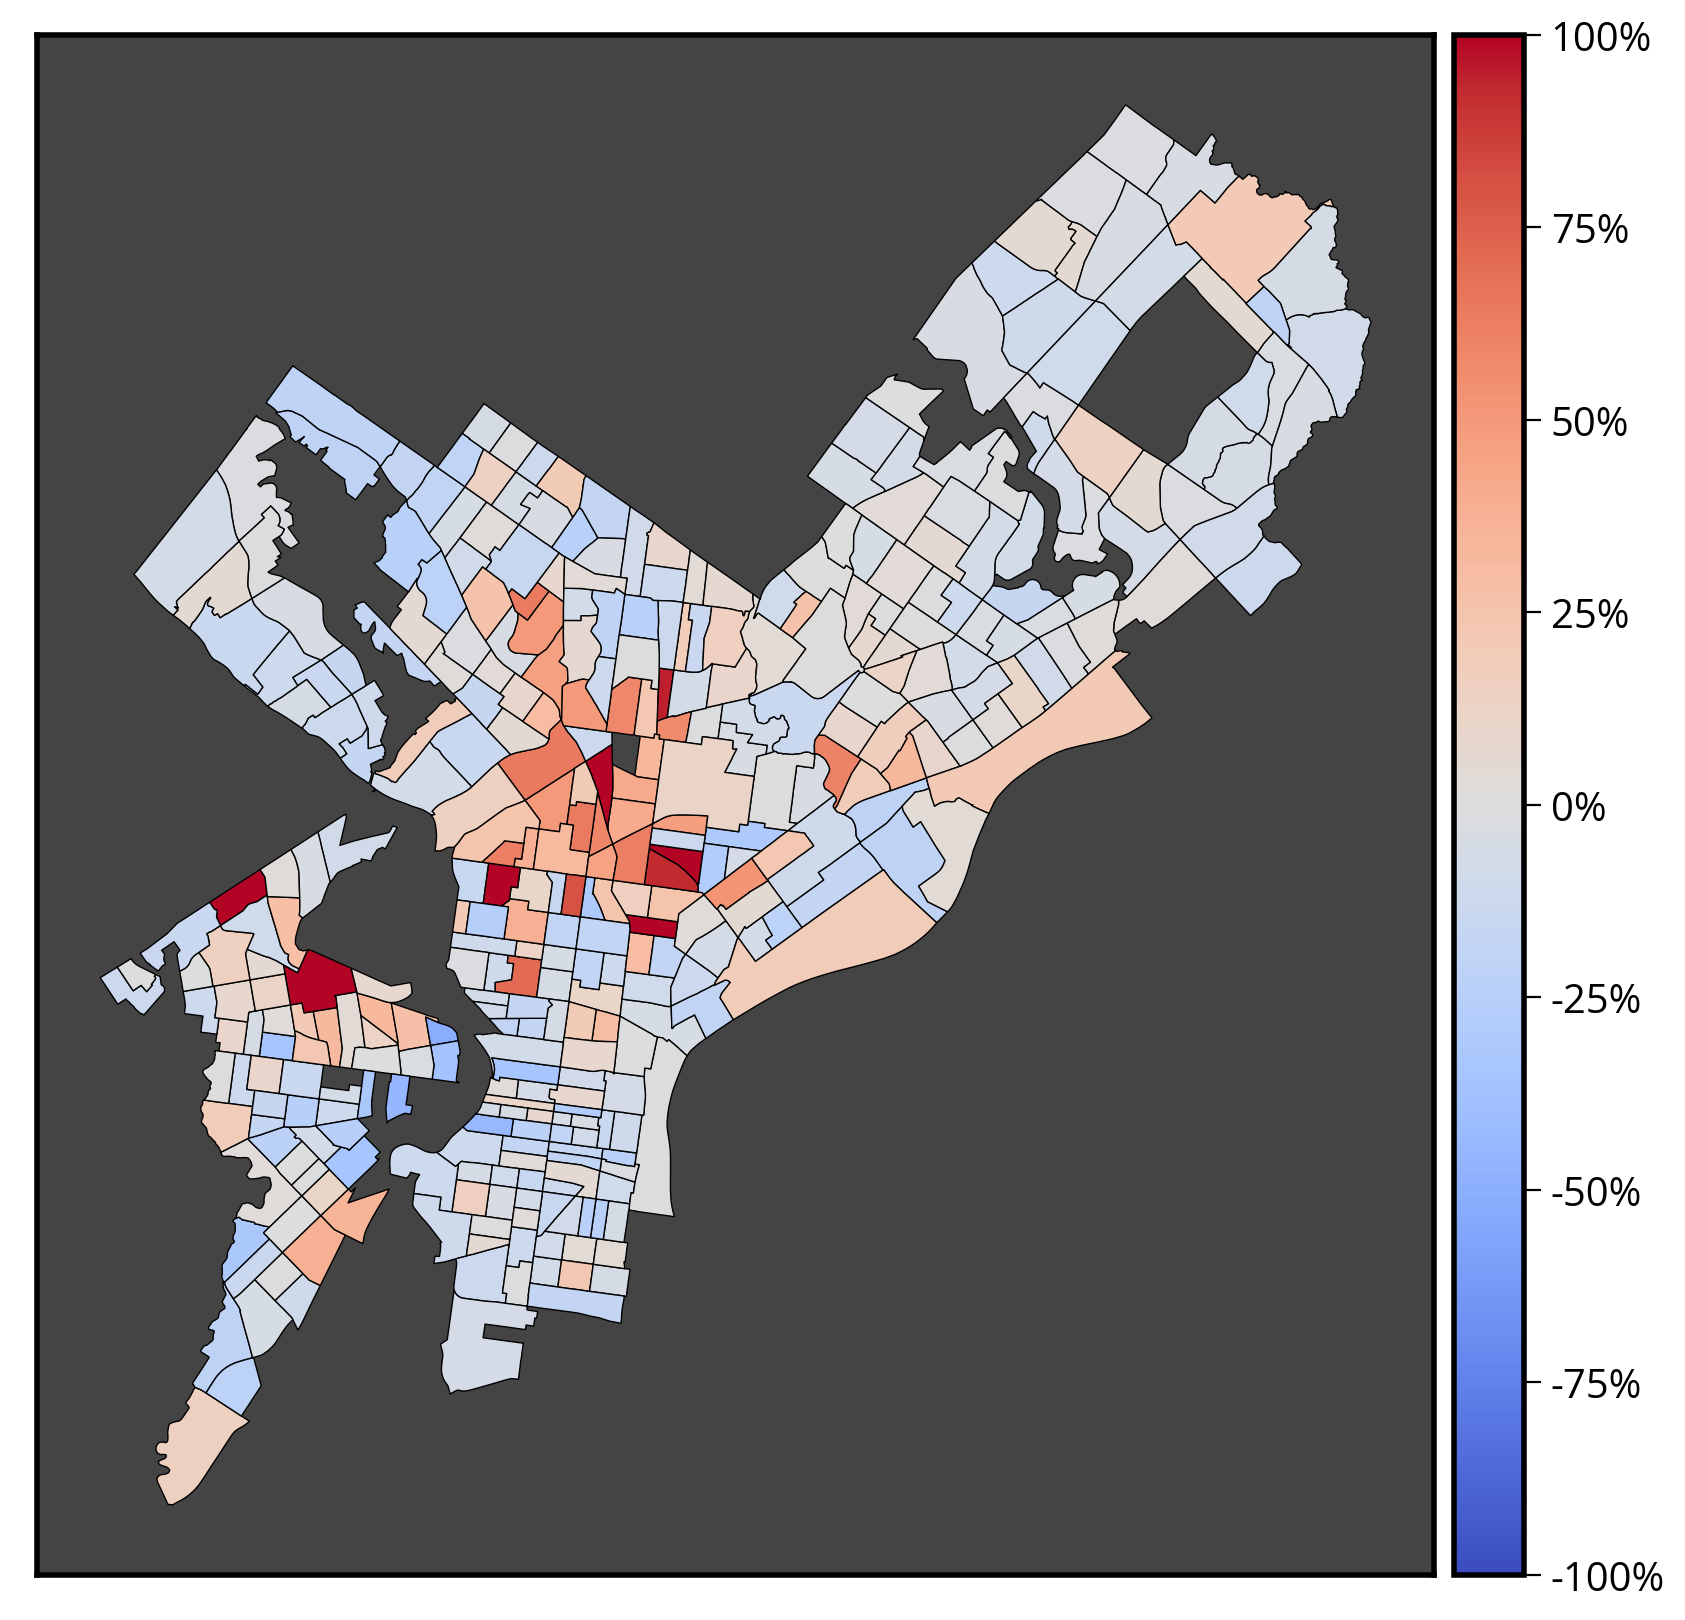

In [60]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Setup the colorbar axes
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Plot
median_errors.to_crs(epsg=2272).plot(
    ax=ax,
    column="percent_error",
    vmin=-100,
    vmax=100,
    legend=True,
    cax=cax,
    cmap="coolwarm",
    edgecolor="k",
    linewidth=0.5,
)

# Format
ax.set_facecolor("#444444")
ax.set_xticks([])
ax.set_yticks([])
cax.set_yticklabels([f"{x:.0f}%" for x in cax.get_yticks()]);

**The above figure clearly shows that areas of the city with minority populations tend to be over assessed by the model.**

### 2.8 Compare the percent errors in Qualifying Census Tracts and other tracts 

[Qualifying Census Tracts](https://www.huduser.gov/portal/datasets/qct.html) are a poverty designation that HUD uses to allocate housing tax credits

- I've included a list of the census tract names that qualify in Philadelphia
- Add a new column to your dataframe of test set sales that is True/False depending on if the tract is a QCT
- Then, group by this new column and calculate the median percent error

**You should find that the algorithm's accuracy is significantly worse in these low-income, qualifying census tracts**

In [61]:
qct = ['5',
 '20',
 '22',
 '28.01',
 '30.01',
 '30.02',
 '31',
 '32',
 '33',
 '36',
 '37.01',
 '37.02',
 '39.01',
 '41.01',
 '41.02',
 '56',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '69',
 '70',
 '71.01',
 '71.02',
 '72',
 '73',
 '74',
 '77',
 '78',
 '80',
 '81.01',
 '81.02',
 '82',
 '83.01',
 '83.02',
 '84',
 '85',
 '86.01',
 '86.02',
 '87.01',
 '87.02',
 '88.01',
 '88.02',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '98.01',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '119',
 '121',
 '122.01',
 '122.03',
 '131',
 '132',
 '137',
 '138',
 '139',
 '140',
 '141',
 '144',
 '145',
 '146',
 '147',
 '148',
 '149',
 '151.01',
 '151.02',
 '152',
 '153',
 '156',
 '157',
 '161',
 '162',
 '163',
 '164',
 '165',
 '167.01',
 '167.02',
 '168',
 '169.01',
 '169.02',
 '170',
 '171',
 '172.01',
 '172.02',
 '173',
 '174',
 '175',
 '176.01',
 '176.02',
 '177.01',
 '177.02',
 '178',
 '179',
 '180.02',
 '188',
 '190',
 '191',
 '192',
 '195.01',
 '195.02',
 '197',
 '198',
 '199',
 '200',
 '201.01',
 '201.02',
 '202',
 '203',
 '204',
 '205',
 '206',
 '208',
 '239',
 '240',
 '241',
 '242',
 '243',
 '244',
 '245',
 '246',
 '247',
 '249',
 '252',
 '253',
 '265',
 '267',
 '268',
 '271',
 '274.01',
 '274.02',
 '275',
 '276',
 '277',
 '278',
 '279.01',
 '279.02',
 '280',
 '281',
 '282',
 '283',
 '284',
 '285',
 '286',
 '287',
 '288',
 '289.01',
 '289.02',
 '290',
 '291',
 '293',
 '294',
 '298',
 '299',
 '300',
 '301',
 '302',
 '305.01',
 '305.02',
 '309',
 '311.01',
 '312',
 '313',
 '314.01',
 '314.02',
 '316',
 '318',
 '319',
 '321',
 '325',
 '329',
 '330',
 '337.01',
 '345.01',
 '357.01',
 '376',
 '377',
 '380',
 '381',
 '382',
 '383',
 '389',
 '390']

In [62]:
median_errors['qct'] = False
median_errors.loc[median_errors['NAME10'].isin(qct), 'qct'] = True

In [63]:
median_errors.groupby("qct")['percent_error'].median()

qct
False   -6.435224
True     2.288342
Name: percent_error, dtype: float64

**The non-qualifying census tracts tend to be under-assessed while qualifying tracts tend to be over-assessed.**